In [1]:
#!pip install ortools
from ortools.sat.python import cp_model

# Colombian Sudoku

In this new sudoku variation, your goal is to solve the puzzle on the left following the standard rules: Each digit from 1 to 9 must appear exactly once in each row, column, and outlined region, with no repeated digits. You'll notice that not many digits have been pre-filled. This is where the diagram on the right comes into play: The dots above and to the right of that diagram indicate how many cells in the corresponding column or row will contain the same digit in the solved grid on the left.

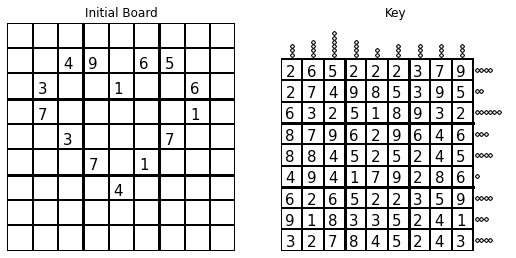

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams['figure.dpi'] = 150

n = 9

given = {(4,2): 4,
         (3,3): 7, (5,3): 1,
         (2,4): 3, (6,4): 7,
         (1,5): 7, (7,5): 1, 
         (1,6): 3, (4,6): 1, (7,6): 6,
         (2,7): 4, (3,7): 9, (5,7): 6, (6,7): 5
         }

given2 = [[3, 2, 7, 8, 4, 5, 2, 4, 3],
       [9, 1, 8, 3, 3, 5, 2, 4, 1],
       [6, 2, 6, 5, 2, 2, 3, 5, 9],
       [4, 9, 4, 1, 7, 9, 2, 8, 6],
       [8, 8, 4, 5, 2, 5, 2, 4, 5],
       [8, 7, 9, 6, 2, 9, 6, 4, 6],
       [6, 3, 2, 5, 1, 8, 9, 3, 2],
       [2, 7, 4, 9, 8, 5, 3, 9, 5],
       [2, 6, 5, 2, 2, 2, 3, 7, 9]]

top = {0: 3, 1: 4, 2: 6, 3: 4, 4: 2, 5: 3, 6: 3, 7: 3, 8: 3}
right = {0: 4, 1: 3, 2: 4, 3: 1, 4: 4, 5: 3, 6: 6, 7: 2, 8: 4}

data = np.zeros((n, n))
fig, ax = plt.subplots(1,2, figsize=(n,n))

for x in [0,1]:
    ax[x].pcolormesh(data, cmap= 'binary', edgecolors='k', linewidth= .2)
    ax[x].set_aspect('equal')

    for i in range(n):
        for j in range(n):
            if (i,j) in given and x == 0:
                ax[x].text(i+.2,j+.2,given[i,j], fontsize = 15)
                ax[x].title.set_text('Initial Board')
            elif x == 1:
                count = 0.2
                ax[x].text(j+.2,i+.2,given2[i][j], fontsize = 15)
                ax[x].title.set_text('Key')
                for a in range(top[i]):
                    ax[x].scatter(i+.5,n+count, marker = '.', c = 'w', edgecolor = 'k', linewidth = .6)
                    count+=.2
                count = 0.2
                for b in range(right[i]):
                    ax[x].scatter(n+count, i+.5, marker = '.', c = 'w', edgecolor = 'k', linewidth = .6)
                    count+=.2
                
    ax[x].plot((3,3),(0,9), c= 'k', linewidth = 3, zorder=10)
    ax[x].plot((6,6),(0,9), c= 'k', linewidth = 3, zorder=10)
    ax[x].plot((0,9),(3,3), c= 'k', linewidth = 3, zorder=10)
    ax[x].plot((0,9),(6,6), c= 'k', linewidth = 3, zorder=10)

    ax[x].axis('off');

In [3]:
class VarArraySolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self, x):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__x = x
        self.__solution_count = 0


    def on_solution_callback(self):
        self.__solution_count += 1
        sol = np.array([self.Value(self.__x[i,j]) for i,j in self.__x.keys()])
        sol = np.reshape(sol, (n,n))
        #print(f'Solution {self.__solution_count}', '\n', sol)

        fig, ax = plt.subplots(1,2, figsize=(n,n))

        for x in [0,1]:
            ax[x].pcolormesh(data, cmap= 'binary', edgecolors='k', linewidth= .2)
            ax[x].set_aspect('equal')

            for i in range(n):
                for j in range(n):
                    if x == 0:
                        ax[x].text(i+.2,j+.2,sol[8-j,i], fontsize = 15)
                        ax[x].title.set_text('Completed Board')
                    elif x == 1:
                        count = 0.2
                        ax[x].text(j+.2,i+.2,given2[i][j], fontsize = 15)
                        ax[x].title.set_text('Key')
                        for a in range(top[i]):
                            ax[x].scatter(i+.5,n+count, marker = '.', c = 'w', edgecolor = 'k', linewidth = .6)
                            count+=.2
                        count = 0.2
                        for b in range(right[i]):
                            ax[x].scatter(n+count, i+.5, marker = '.', c = 'w', edgecolor = 'k', linewidth = .6)
                            count+=.2
                        
            ax[x].plot((3,3),(0,9), c= 'k', linewidth = 3, zorder=10)
            ax[x].plot((6,6),(0,9), c= 'k', linewidth = 3, zorder=10)
            ax[x].plot((0,9),(3,3), c= 'k', linewidth = 3, zorder=10)
            ax[x].plot((0,9),(6,6), c= 'k', linewidth = 3, zorder=10)

            ax[x].axis('off');

    def solution_count(self):
        return self.__solution_count

Status = OPTIMAL


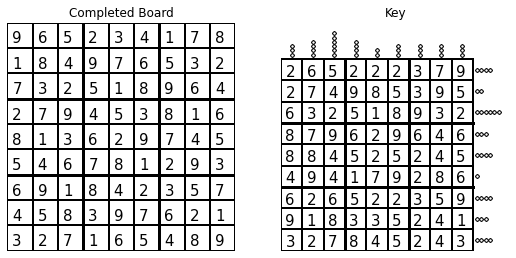

In [4]:
import math

# Creates the model and set solver
model = cp_model.CpModel()
solver = cp_model.CpSolver()

x = {(i,j): model.NewIntVar(1, n, f'x_{i}_{j}') for i in range(n) for j in range(n)}

row = {(i,j): model.NewBoolVar(f'row_{i}_{j}') for i in range(n) for j in range(n)}
col = {(i,j): model.NewBoolVar(f'col_{i}_{j}') for i in range(n) for j in range(n)}

# Each column and row contains all numbers
for i in range(n):
    model.AddAllDifferent([x[i,j] for j in range(n)])
    model.AddAllDifferent([x[j,i] for j in range(n)])

# Each sqrt(n) by sqrt(n) section contains all number 1-n

for a in range(int(math.sqrt(n))):
    for b in range(int(math.sqrt(n))):
        model.AddAllDifferent([x[i+a*int(math.sqrt(n)),j+b*int(math.sqrt(n))] \
                               for i in range(int(math.sqrt(n))) for j in range(int(math.sqrt(n)))])

# Populating given squares into model
for (i,j) in given:
    model.Add(x[8-j,i] == given[i,j])

# Each row and col has exactly as many correct values as is given
for i in range(n):
    for j in range(n):
        model.Add(x[i,j] == np.flipud(given2)[i][j]).OnlyEnforceIf(row[i,j])
        model.Add(x[i,j] != np.flipud(given2)[i][j]).OnlyEnforceIf(~row[i,j])

        model.Add(x[j,i] == np.flipud(given2)[j][i]).OnlyEnforceIf(col[i,j])
        model.Add(x[j,i] != np.flipud(given2)[j][i]).OnlyEnforceIf(~col[i,j])

    model.Add(sum(row[i,j] for j in range(n)) == right[8-i])
    model.Add(sum(col[i,j] for j in range(n)) == top[i])

# Enumerate all solutions.
solver.parameters.enumerate_all_solutions = True

solution_printer = VarArraySolutionPrinter(x)

status = solver.Solve(model, solution_printer)

print(f"Status = {solver.StatusName(status)}")